In [3]:
import dolfin
import pyurdme
import numpy
import math
import matplotlib.pyplot as plt
import sys
from scipy import stats
import pickle

ImportError: dlopen(/Applications/FEniCS.app/Contents/Resources/lib/python2.7/site-packages/dolfin/cpp/_common.so, 2): Library not loaded: libdolfin.1.6.dylib
  Referenced from: /Applications/FEniCS.app/Contents/Resources/lib/python2.7/site-packages/dolfin/cpp/_common.so
  Reason: image not found

In [2]:
sys.path.append("/Users/andreash/bitbucket/nllattice")
class normal_diffusion(pyurdme.URDMEModel):
    """ Initial condition is a delta function at the center voxel. 
        The solution should be a Gaussian, up to the point where
        the BC becomes important. """

    def __init__(self,name="diffusion",rho=0.1,nx=40):
    
        pyurdme.URDMEModel.__init__(self,name=name)

        D = 0.5
        R = 1.0
        A = pyurdme.Species(name="A",reaction_radius=R,diffusion_constant=D)
        
        # Crowding agents
        B = pyurdme.Species(name="B",reaction_radius=R,diffusion_constant=D)
        #C = pyurdme.Species(name="C",reaction_radius=0.0025,diffusion_constant=0)
        #D = pyurdme.Species(name="D",reaction_radius=0.0050,diffusion_constant=D)
        #N = 2000
        
        L = 100
        V = L**2
        N = int(V*rho/(math.pi*R**2))
        
        self.add_species([A,B])

        # A (1x1) micrometer sidelength square
        print (L/nx)/(math.pi)
        #self.mesh = pyurdme.URDMEMesh.generate_square_mesh(L,nx,nx)
        domain = dolfin.Rectangle(0,0,L,L)
        self.mesh = pyurdme.URDMEMesh(mesh=dolfin.Mesh(domain,nx))

        # Place one A molecules in the voxel closest to the center of the square
        self.set_initial_condition_place_near({A:1},point=numpy.array([0.5,0.5])*L)
        
        # Distribute crowders randomly in the domain.
        self.set_initial_condition_scatter({B:N})
        #self.set_initial_condition_scatter({C:500})
        #self.set_initial_condition_scatter({D:1000})
        
        self.timespan(numpy.linspace(0,50,1000))


In [3]:
rho = 0.4
(100/60.0)**2/(math.pi)
L = 100
V = L**2
R = 1
N = int(V*rho/(math.pi*R**2))
print rho,N

0.4 1273


In [9]:
def msd(result):
    A = result.get_species("A")
    
    p = result.model.mesh.get_normalized_coordinates()
    
    dims = numpy.shape(A)
    msd = numpy.zeros((1,dims[0]))
    
    dist = numpy.linalg.norm(p,ord=2,axis=1)
    dist = numpy.power(dist,2)
    
    for time in range(dims[0]):
        msd[0,time]=numpy.dot(dist,A[time,:])/numpy.sum(A[time, :])
    
    msd[0,0] = 0
    return msd

In [9]:
%pylab inline
from scipy import stats
import pickle
import nemsolver

def es_d(model):
    solver2 = nemsolver.NEMSolver(model, solver_path="/Users/andreash/bitbucket/nllattice/")
    N = 1000
    for i in xrange(N):
        if i==0:
            m2 = msd(solver2.run())
        else:
            m2 = m2+msd(solver2.run())
    m2 = m2/N
    msd2 = m2[0]
    return msd2
   
rhos = [0.01,0.1,0.2,0.3]
rhos=[0.3]
d = []
emsds = []
for rho in rhos:
    model = normal_diffusion(rho=rho, nx=40)
    emsd = es_d(model)
    emsds.append(emsd)
# result[rho] = emsd
result = {'rhos':rhos, 'msds':emsds,'tspan':model.tspan}
     
fh = open("data/test.pyb", "wb")
fh.write(pickle.dumps(result))

Populating the interactive namespace from numpy and matplotlib
0.636619772368


In [5]:
model=normal_diffusion()

DEBUG:UFL:No integrals left after transformation, returning empty form.
DEBUG:FFC:Reusing form from cache.


0.636619772368


Populating the interactive namespace from numpy and matplotlib
[0.46914776225366916, 0.30809624134191582, 0.22064300899425945, 0.13367656360025137]


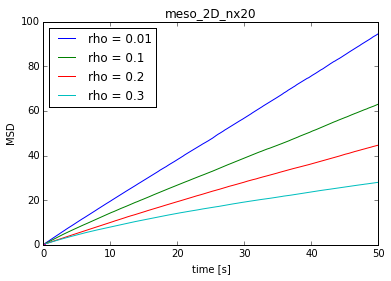

In [9]:
import pickle
%pylab inline
fn = "meso_2D_nx20"
fh = open("data/meso_2D_nx10_tf50s_ntraj50k.pyb","r")
#fh = open("data/test.pyb")
res = pickle.load(fh)
msds = res['msds']
#print msds[0]
rhos = res['rhos']
#model = res['model']

import json
for_ben = {}
for_ben["tspan"] = list(model.tspan)
for_ben["rho01"]=list(msds[0])
#with open("for_ben.json",'wb') as fh:
 #   fh.write(json.dumps(for_ben))

deff = []
d = []
for i,rho in enumerate(rhos):
    plt.plot(model.tspan, msds[i])
    
    # Estimate effective long-time diffusion constant
    start = 1
    stop = -1
    alpha2 = stats.linregress(model.tspan[start:stop:],msds[i][start:stop:])
    d.append(alpha2[0]/4.0)

l = []
for rho in rhos:
    l.append("rho = {0}".format(rho))
plt.legend(l, loc=0)
plt.title(fn)
plt.xlabel("time [s]")
plt.ylabel("MSD")
# Effective diffusion constants
print d
plt.plot(rhos,d)